# Tree Ring Analysis: Comparasion

Author: Johnny Esteves, University Of Michigan

### Description
Here we compare tree ring signal (second moments and astro. shift) with the flat field signal.

In [1]:
%reset -f
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rc('image', interpolation='bicubic', origin='lower', cmap = 'viridis')
plt.rcParams["axes.formatter.useoffset"] = False
plt.rcParams['figure.figsize'] = [14.0, 10.0]
plt.rcParams['font.size'] = 16
rcParams = plt.rcParams.copy()


import posixpath, datetime, sys
import cv2

from scipy.stats import binned_statistic_2d, binned_statistic
from skimage.measure import block_reduce
from skimage.util import view_as_blocks
from scipy.ndimage.filters import gaussian_filter
import scipy.optimize as opt

#
from scipy.signal import butter, sosfilt

In [2]:
import os
import glob
import numpy as np
import fitsio as fits
import matplotlib.pyplot as plt


# Load Data

In [3]:
# ## fix an offset

# offset = dr[0][0]-dT[0][0]
# print(offset)

In [4]:
def plot_profile(out,ax=None,color=None,unit='pixel',label="",fill=False,factor=1.,percentage=False,alpha=0.8):
    x,y,ym,yp = out[0], out[1], out[3], out[4]
    
    pr=1.
    if percentage: pr=100.
        
    if ax is None: ax=plt.axes()
    p     = ax.plot(x, factor*y*pr, lw=2, color=color,label=label,alpha=alpha)
    ax.plot(x,0.*x, 'k',ls=(0, (3, 10, 1, 10)),lw=2)
    color = p[0].get_color()
    if fill:    ax.fill_between(x,factor*pr*ym,factor*pr*yp,alpha=0.3, label=None, color=color)
        
    ax.set_xlabel('radii [pixels]')
    ax.set_ylabel('dev. from mean [%s]'%(unit))

In [5]:
from scipy.signal import find_peaks

def get_factor(list1,list2,is_range=True):
    x = list1[1]
    y = list2[1]
    
    if is_range: x = x[(list2[0]).astype(int)-(list1[0][0]).astype(int)]
    
#     peaks1, _ = find_peaks(np.abs(x), width=10, height=np.percentile(np.abs(x),25))
#     peaks2, _ = find_peaks(np.abs(y), width=10, height=np.percentile(np.abs(y),25))
#     factor = np.max(y[peaks2])/np.max(x[peaks1])
    
    xstd = np.nanstd(x)
    ystd = np.nanstd(y)
    
    factor = ystd/xstd
    print('factor: %.2e'%factor)
    return factor

## Profile Plots

In [102]:
sensor = 'ITL'
dr = np.load('profiles/polar_{}_{}.npy'.format(sensor,'dr'))
dT = np.load('profiles/polar_{}_{}.npy'.format(sensor,'dT'))
dF = np.load('profiles/polar_{}_{}.npy'.format(sensor,'flat'))

# dXX= np.load('profiles/polar_{}_{}.npy'.format(self.sensor,'dXX'))
# dYY= np.load('profiles/polar_{}_{}.npy'.format(self.sensor,'dYY'))
# dT = np.load('profiles/polar_{}_{}.npy'.format(self.sensor,'dT'))
# dg1= np.load('profiles/polar_{}_{}.npy'.format(self.sensor,'dg1'))
# dg2= np.load('profiles/polar_{}_{}.npy'.format(self.sensor,'dg2'))

In [103]:
title = '%s - R02 S02 - 9Raft Data'%(sensor)

In [104]:
border = 50
rmin, rmax = dr[0][0]-border, dr[0][-1]+border

### Derivative of the flat field signal

Which window size?

(-0.0075, 0.0075)

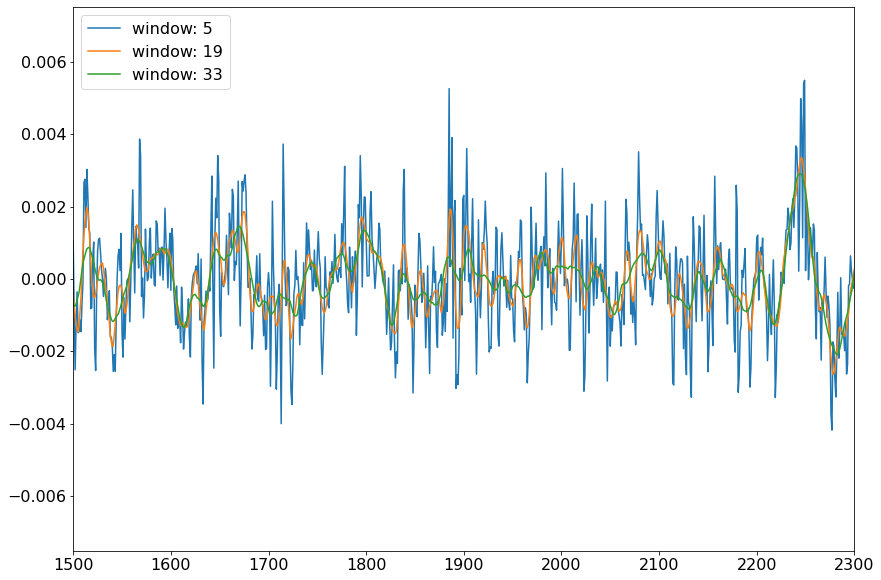

In [105]:
from scipy.signal import savgol_filter, general_gaussian

p      = 3
signal = dF[1]
for i in range(3):
    window = (14*i+5)
    der = savgol_filter(signal, window, polyorder = p, deriv=1)
    plt.plot(der, label='window: %i'%(window))
    
plt.legend()
plt.xlim(1500,2300)
plt.ylim(-0.0075,0.0075)

## Astro. Shift

The astrometric shift is a pertubation in pixels while the flat field has a siganl related with pixel intensity per area. The relation between this two signal is given by:
$$
f(r) = \frac{1}{r}\int_{0}^{r} r^\prime w(r^\prime) dr^\prime
$$

From Plazas et al. 2014 - See their equation (3).

The inverse relation is simply $w(r) = \frac{df(r)}{dr}$

In [106]:
from scipy.signal.signaltools import wiener

In [107]:
import scipy
def integrate_signal(r,signal,fs=1000,window=31,p=3):
    noisy= np.zeros_like(r)
    noisy[1:] = np.array([scipy.integrate.simps(r[:i]*signal[:i],x=r[:i])/r[i] for i in range(1,len(r))])
    
#     sos      = butter(1, 5., 'hp', fs=fs, output='sos')
#     filtered = sosfilt(sos, noisy)

    filtered = low_pass_filter(r,signal,freq=1/fs)
    
    res  = savgol_filter(filtered, window, polyorder = p, deriv=0)
    return filtered

In [108]:
import numpy as np
from scipy.fftpack import rfft, irfft, fftfreq

def low_pass_filter(time,signal,freq=1/150):
    W = fftfreq(signal.size, d=time[1]-time[0])
    f_signal = rfft(signal)

    # If our original signal time was in seconds, this is now in Hz    
    cut_f_signal = f_signal.copy()
    cut_f_signal[(W<freq)] = 0

    cut_signal = irfft(cut_f_signal)
    return cut_signal

In [109]:
r = dF[0]
signal = dF[1]

noisy= np.zeros_like(r)
noisy[1:] = np.array([scipy.integrate.simps(r[:i]*signal[:i],x=r[:i])/r[i] for i in range(1,len(r))])

filtered = []
for i in range(4):
    #sos      = butter(1, 5., 'hp', fs=500*(i+1), output='sos')
    #filtered.append(sosfilt(sos, noisy))
    filtered.append(low_pass_filter(r,noisy,freq=1/(100*(i+1))))

Text(0.5, 0, 'radii [pixels]')

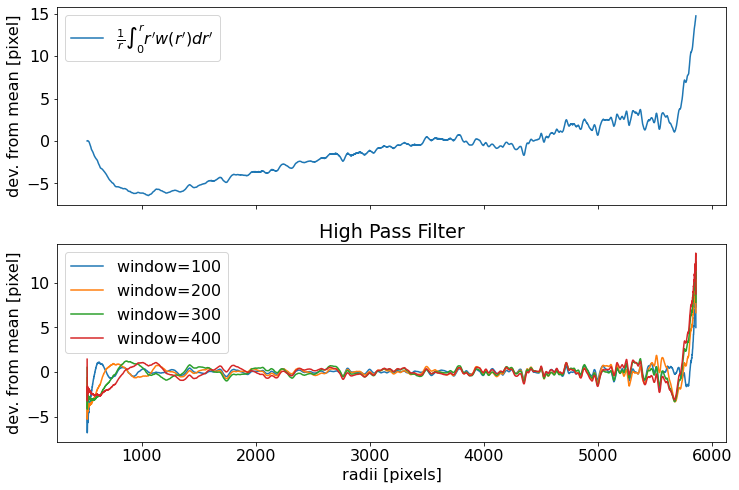

In [118]:
fig, ax = plt.subplots(2, 1, sharex='all', figsize=(12, 8))

ax[0].plot(r,noisy,label=r'$\frac{1}{r}\int_{0}^{r} r^\prime w(r^\prime) dr^\prime$')
ax[0].legend()
ax[0].set_ylabel('dev. from mean [%s]'%('pixel'))

ax[1].set_title('High Pass Filter')
for i in range(4):
    ax[1].plot(r,filtered[i],label=r'window=$%i$'%((i+1)*100))

ax[1].legend()

#ax[1].set_xlim(rmin,rmax)
ax[1].set_ylabel('dev. from mean [%s]'%('pixel'))
ax[1].set_xlabel('radii [pixels]')


In [111]:
def get_frac_error(x,y):
    return (x-y)#/np.max(np.abs(np.vstack([x,y])),0)

Text(0.5, 0, 'radii [pixels]')

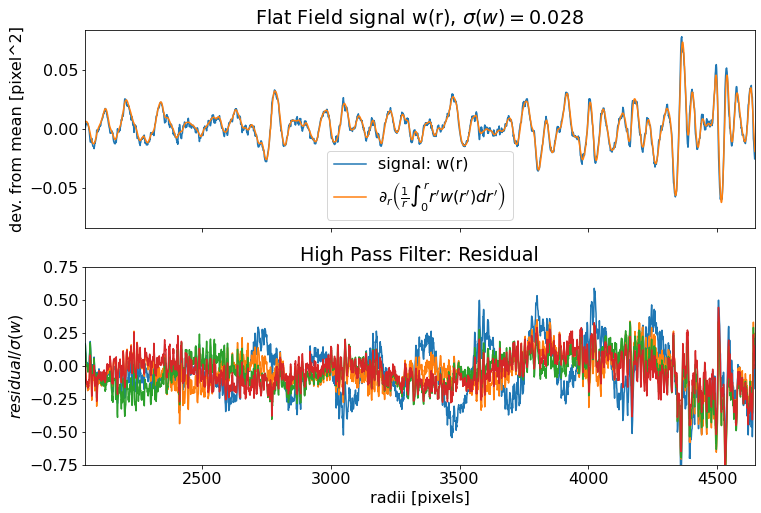

In [112]:
fig, ax = plt.subplots(2, 1, sharex='all', figsize=(12, 8))

ymax = 3*np.std(signal)

ax[0].set_title('Flat Field signal w(r), $\sigma(w)=%.3f$'%(ymax/3.))
ax[0].plot(r,signal,label=r'signal: w(r)')
ax[0].plot(r,savgol_filter(noisy, 35, polyorder = 3, deriv=1),label=r'$\partial_r \left(\frac{1}{r}\int_{0}^{r} r^\prime w(r^\prime) dr^\prime\right)$')
ax[0].legend()
ax[0].set_ylabel('dev. from mean [%s]'%('pixel^2'))
ax[0].set_ylim(-ymax,ymax)

ax[1].set_title('High Pass Filter: Residual')
for i in range(4):
    diff = get_frac_error(savgol_filter(filtered[i], 35, polyorder = 3, deriv=1),signal)/(ymax/3)
    ax[1].plot(r,diff,label=r'window=$%i$'%((i+1)*500))

ax[1].set_ylim(-0.75,0.75)    
# ax[1].legend()
ax[1].set_xlim(rmin,rmax)
ax[1].set_ylabel('$residual/\sigma(w)$')
ax[1].set_xlabel('radii [pixels]')


In [113]:
wlabel= r'$\frac{1}{r}\int_{0}^{r} r^\prime w(r^\prime) dr^\prime$'

In [123]:
window = 31
p      = 3

# # dF2 = [dF[0]]
# # dF2+= [savgol_filter(signal, window, polyorder = p, deriv=1) for signal in dF[1:]]

dF2 = [dF[0]]
dF2+= [integrate_signal(dF[0], signal, fs=250, window=window, p = p) for signal in dF[1:]]

dF3 = [dF[0]]
dF3+= [integrate_signal(dF[0], signal, fs=150, window=window, p = p) for signal in dF[1:]]


dr2 = [dr[0]] 
dr2+= [savgol_filter(signal, window, polyorder = p, deriv=0) for signal in dr[1:]]

In [124]:
factor = get_factor(dF2,dr)

factor: 1.48e+01


Text(0.5, 1.0, 'ITL - R02 S02 - 9Raft Data')

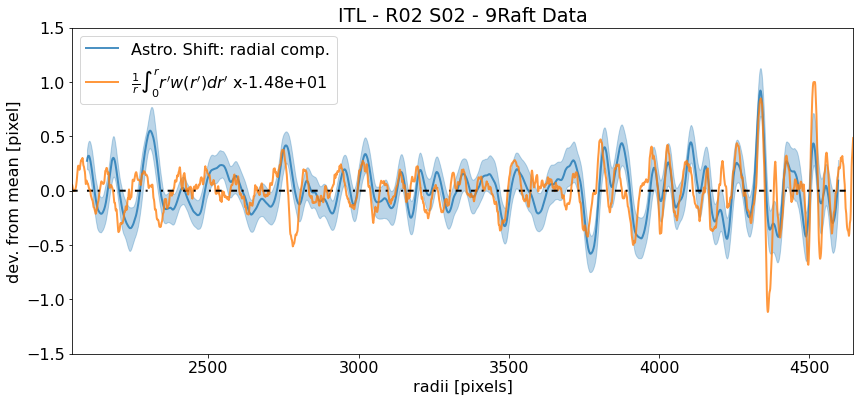

In [125]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
plot_profile(dr2,label='Astro. Shift: radial comp.',ax=ax,fill=True)
plot_profile(dF2,label='%s x%.2e'%(wlabel,-1*factor),ax=ax,factor=-1*factor)
# plot_profile(dF3,label='%s x%.2e'%(wlabel,-1*factor),ax=ax,factor=-1*factor)

ax.legend(fontsize=16)
ax.set_xlim(rmin,rmax)
ax.set_ylim(-1.5,1.5)
ax.set_title(title)#+' - window=%i pixels'%window)

In [87]:
window = 11
p      = 3

dF2 = [dF[0]]
dF2+= [savgol_filter(signal, window, polyorder = p, deriv=1) for signal in dF[1:]]

dr2 = [dr[0]] 
dr2+= [savgol_filter(signal, window, polyorder = p, deriv=0) for signal in dr[1:]]

In [89]:
# fig, ax = plt.subplots(1, 1, figsize=(14, 6))
# plot_profile(dr2,label='Astro. Shift: radial comp.',ax=ax,fill=True)
# plot_profile(dF2,label='First Der. Flat Field x%.2e'%(factor),ax=ax,factor=+1*factor,alpha=0.6)

# ax.legend(fontsize=16)
# ax.set_xlim(rmin,rmax)
# ax.set_ylim(-1.,1.)
# ax.set_title(title+' - window=%i pixels'%window)

In [351]:
factor = get_factor(dF,dr)

factor: 1.46e+01


Text(0.5, 1.0, 'ITL - R02 S02 - 9Raft Data')

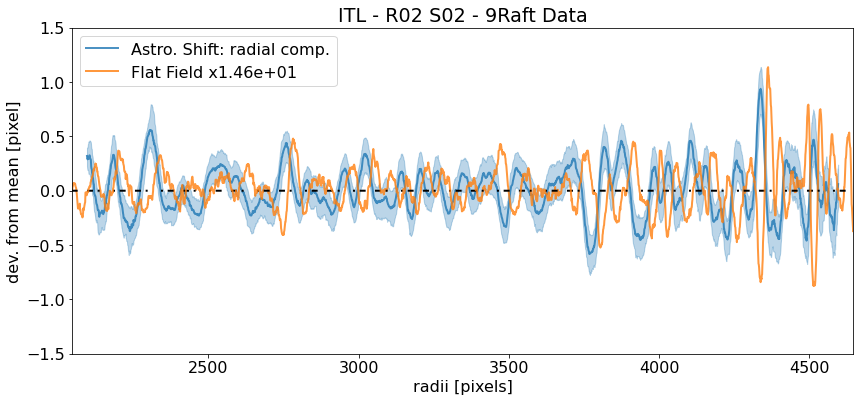

In [352]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
plot_profile(dr,label='Astro. Shift: radial comp.',ax=ax,fill=True)
plot_profile(dF,label='Flat Field x%.2e'%(factor),ax=ax,factor=+1*factor)
ax.legend(fontsize=16)
ax.set_xlim(rmin,rmax)
ax.set_ylim(-1.5,1.5)
ax.set_title(title)

The astrometric shift signal agrees with the derivative flat field. Note the phase shift at high radii.

## Second Moments

In [353]:
factor = get_factor(dF,dT)

factor: 1.05e+01


Text(0.5, 1.0, 'ITL - R02 S02 - 9Raft Data')

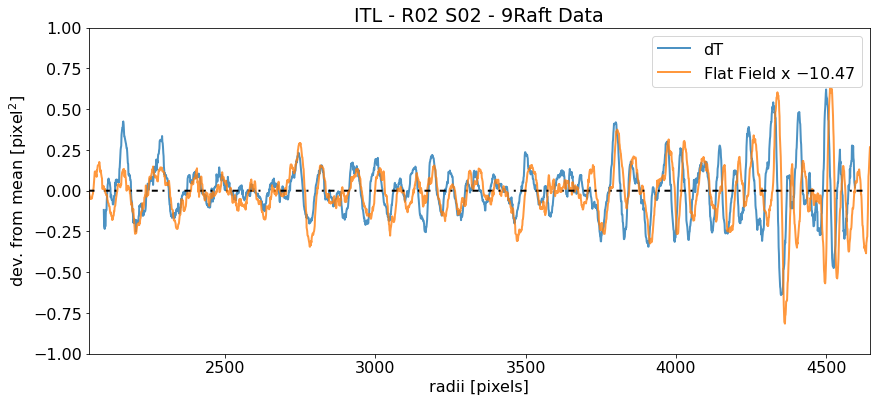

In [354]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
plot_profile(dT,label='dT',ax=ax,fill=False)
plot_profile(dF,label=r'Flat Field x $-%.2f$'%(factor),
             ax=ax,factor=-1*factor,unit='pixel$^2$')
ax.legend(fontsize=16)
ax.set_xlim(rmin,rmax)

ax.set_ylim(-1.,1.)
ax.set_title(title)

## Comparing Second Moments and Astro. Shift

In [355]:
window = 61
dT2 = [dT[0]] 
dT2+= [savgol_filter(signal, window, polyorder = p, deriv=1) for signal in dT[1:]]

In [356]:
factor = get_factor(dT2,dr2,is_range=False)

factor: 1.92e+01


Text(0.5, 1.0, 'ITL - R02 S02 - 9Raft Data')

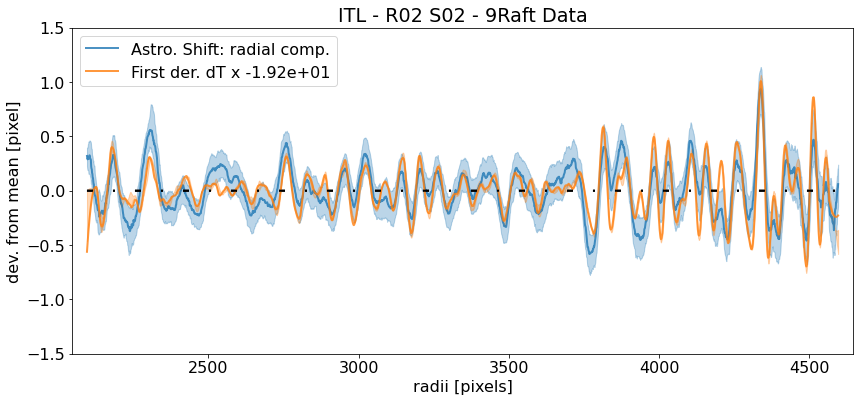

In [357]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
plot_profile(dr,label='Astro. Shift: radial comp.',ax=ax,fill=True)
plot_profile(dT2,label='First der. dT x %.2e'%(-1*factor),ax=ax,factor=-1*factor,fill=True)
ax.legend(fontsize=16)
ax.set_ylim(-1.5,1.5)
ax.set_xlim(rmin,rmax)
ax.set_title(title)

# E2V - R11 S22

In [22]:
sensor = 'e2v'
dr = np.load('profiles/polar_{}_{}.npy'.format(sensor,'dr'))
dT = np.load('profiles/polar_{}_{}.npy'.format(sensor,'dT'))
dF = np.load('profiles/polar_{}_{}.npy'.format(sensor,'flat'))

In [23]:
offset = dr[0][0]-dT[0][0]
# offset = 0
print('offset: %.2f'%(offset))

dr[0] -= offset

offset: 0.00


In [24]:
title = '%s - R11 S22 - 9Raft Data'%(sensor)

In [25]:
border = 50
rmin, rmax = dT[0][0]-border, dT[0][-1]+border

In [26]:
window = 71
p      = 3

dF2 = [dF[0]]
dF2+= [savgol_filter(signal, window, polyorder = p, deriv=1) for signal in dF[1:]]

dr2 = [dr[0]] 
dr2+= [savgol_filter(signal, window, polyorder = p, deriv=0) for signal in dr[1:]]

dT2 = [dr[0]] 
dT2+= [savgol_filter(signal, window, polyorder = p, deriv=1) for signal in dT[1:]]

## Astro. Shift

In [27]:
factor = get_factor(dF2,dr2)

factor: 2.08e+02


In [28]:
# dr2 = np.load('../profiles/polar_{}_{}.npy'.format(sensor,'dr'))

Text(0.5, 1.0, 'e2v - R11 S22 - 9Raft Dataw/ window = 71')

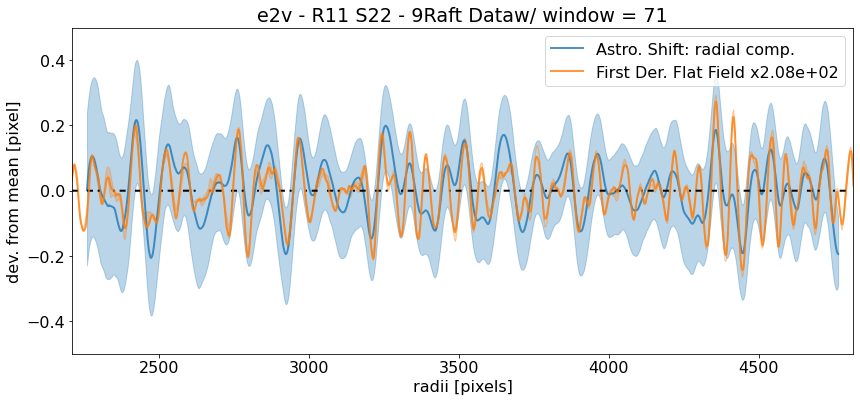

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
plot_profile(dr2,label='Astro. Shift: radial comp.',ax=ax,fill=True)
# plot_profile(dr2,label='Astro. Shift: in pixel',ax=ax,fill=False,factor=1/20)
plot_profile(dF2,label='First Der. Flat Field x%.2e'%(factor),ax=ax,factor=+1*factor, fill = True)
ax.legend(fontsize=16)
ax.set_xlim(rmin,rmax)
ax.set_ylim(-0.5,0.5)
ax.set_title(title + 'w/ window = %i'%window)

## Second Moments

In [30]:
factor = get_factor(dF,dT)

factor: 1.23e+01


Text(0.5, 1.0, 'e2v - R11 S22 - 9Raft Data')

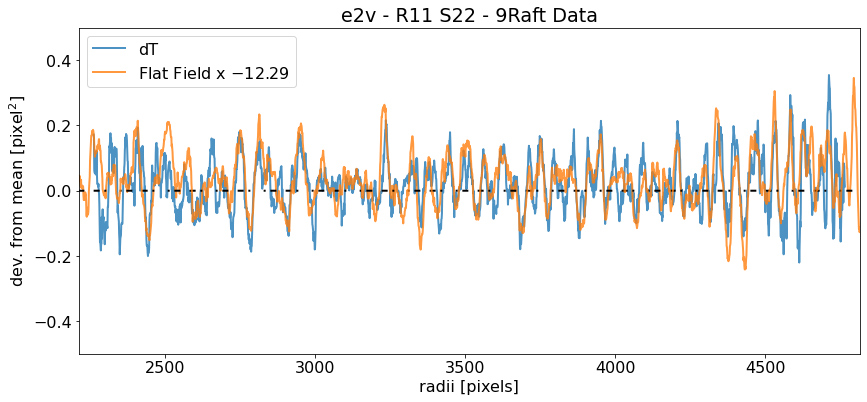

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
plot_profile(dT,label='dT',ax=ax,fill=False)
plot_profile(dF,label=r'Flat Field x $-%.2f$'%(factor),
                ax=ax,factor=-1*factor,unit='pixel$^2$')
ax.legend(fontsize=16)
ax.set_xlim(rmin,rmax)
ax.set_ylim(-0.5,0.5)

ax.set_title(title)

## Comparing Second Moments and Astro. Shift

In [32]:
factor = get_factor(dT2,dr2,is_range=False)

factor: 1.70e+01


Text(0.5, 1.0, 'e2v - R11 S22 - 9Raft Dataw/ window = 71')

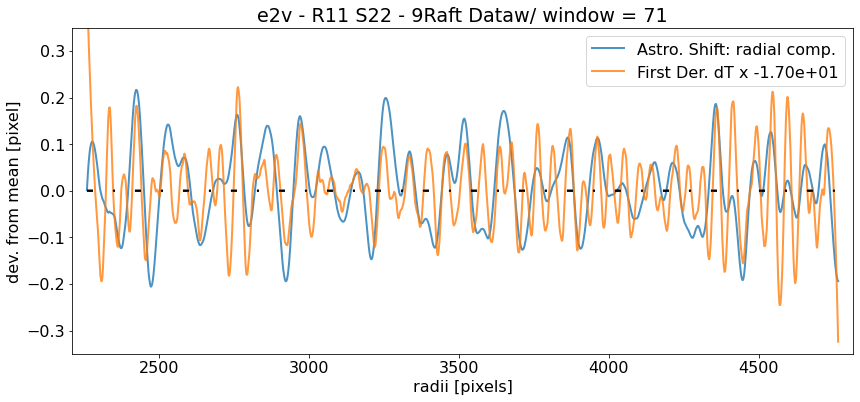

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
plot_profile(dr2,label='Astro. Shift: radial comp.',ax=ax,fill=False)
plot_profile(dT2,label='First Der. dT x %.2e'%(-1*factor),ax=ax,factor=-1*factor)
ax.legend(fontsize=16)
ax.set_xlim(rmin,rmax)
ax.set_ylim(-0.35,0.35)
ax.set_title(title + 'w/ window = %i'%window)

In [34]:
## is dT only noise? Does the e2v has a TR pattern?

# Load Data

Retrieving files path from BUTLER.

In specific, for loading the results after the corrections made on the mixcoatl code by Alex I use the repo_path used `/sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft/butler.yaml` and the collection `u/youtsumi/spot/AlexRecommendation`.


### Initialize the `spotgrid.py` code

In [1]:
import sys
sys.path.append('/gpfs/slac/kipac/fs1/u/esteves/codes/TreeRing/')
from spotgrid_butler import SpotgridCatalog

In [2]:
repo = '/sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft/butler.yaml'
e2v = SpotgridCatalog(repo,
                     'u/asnyder/spot/e2v_analysis_rerun',
                     'u/asnyder/spots/e2v_calibration_rerun/20210625T185250Z',
                      sensor='e2v')

Repository        : /sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft/butler.yaml
catalog collection: u/asnyder/spot/e2v_analysis_rerun
calib collection  : u/asnyder/spots/e2v_calibration_rerun/20210625T185250Z




In [3]:
e2v.get_calibration_table()
e2v.load_data()
e2v.compute_statistics()
e2v.filter_spots()
e2v.compute_spotgrid()
e2v.calibrate()

Found tmp/r22_s11_x_arr.npy
Found tmp/r22_s11_y_arr.npy
Found tmp/r22_s11_xx_arr.npy
Found tmp/r22_s11_xy_arr.npy
Found tmp/r22_s11_yy_arr.npy
Found tmp/r22_s11_dx_arr.npy
Found tmp/r22_s11_dy_arr.npy
Found tmp/r22_s11_dxx_arr.npy
Found tmp/r22_s11_dyy_arr.npy
Found tmp/r22_s11_dxy_arr.npy
Found tmp/r22_s11_instFlux_arr.npy
Found tmp/r22_s11_instFluxErr_arr.npy
Found tmp/r22_s11_x_center_arr.npy
Found tmp/r22_s11_y_center_arr.npy
Found tmp/r22_s11_dFlux_arr.npy
Found tmp/r22_s11_dg1_arr.npy
Found tmp/r22_s11_dg2_arr.npy
Loading data for e2v tmp/r22_s11.
Computing statistics for e2v tmp/r22_s11.
Computing filter spots for e2v tmp/r22_s11.


In [4]:
repo = '/sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft/butler.yaml'
itl = SpotgridCatalog(repo,
                      'u/asnyder/spot/itl_analysis',
                      'u/asnyder/spot/itl_calibration',sensor='ITL')

Repository        : /sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft/butler.yaml
catalog collection: u/asnyder/spot/itl_analysis
calib collection  : u/asnyder/spot/itl_calibration




In [5]:
itl.get_calibration_table()
itl.load_data()
itl.compute_statistics()
itl.compute_spotgrid()
itl.filter_spots()
itl.calibrate()

Found tmp/r02_s02_x_arr.npy
Found tmp/r02_s02_y_arr.npy
Found tmp/r02_s02_xx_arr.npy
Found tmp/r02_s02_xy_arr.npy
Found tmp/r02_s02_yy_arr.npy
Found tmp/r02_s02_dx_arr.npy
Found tmp/r02_s02_dy_arr.npy
Found tmp/r02_s02_dxx_arr.npy
Found tmp/r02_s02_dyy_arr.npy
Found tmp/r02_s02_dxy_arr.npy
Found tmp/r02_s02_instFlux_arr.npy
Found tmp/r02_s02_instFluxErr_arr.npy
Found tmp/r02_s02_x_center_arr.npy
Found tmp/r02_s02_y_center_arr.npy
Found tmp/r02_s02_dFlux_arr.npy
Found tmp/r02_s02_dg1_arr.npy
Found tmp/r02_s02_dg2_arr.npy
Loading data for ITL tmp/r02_s02.
Computing statistics for ITL tmp/r02_s02.
Computing filter spots for ITL tmp/r02_s02.


## Polar Transformation

In [17]:
from tree_ring_helper import *

In [18]:
#help(tree_ring_tools)

In [19]:
#centers = [[4320,-280],[-156,-280],[4320,4180],[-156,4180]]
#centers = [[-310, 4086.36],[-156,-280],[4320,4180],[4439.24, -434.62]]
centers = [[-335.49, 4095.84],[-156,-280],[4320,4180],[4627.47, -630.89]]

sensor_lims = {'e2v':[[0,4096],[0,4004]],'ITL':[[0,4072],[0,4000]]}

In [29]:
def proj_to_polar_coord(t,vx,vy):
    vr = np.cos(t)*vx + np.sin(t)*vy
    vt = -np.sin(t)*vx+ np.cos(t)*vy
    return vr, vt

def proj_to_polar_coord_spin2(t,vx,vy):
    vr = np.cos(2*t)*vx + np.sin(2*t)*vy
    vt = np.sin(2*t)*vx - np.cos(2*t)*vy
    return vr, vt

def trasnform_to_polar_coord(x,y,x0=0.,y0=0.,deg=False):
    r = np.hypot((x-x0),(y-y0))
    t = np.arctan2((y-y0),(x-x0))
    
    if deg: t *= (180 / np.pi)
    return r,t

In [30]:
xc,yc = centers[3]

r, t = trasnform_to_polar_coord(e2v.xfltr_flat,e2v.yfltr_flat, x0=xc, y0=yc)

dr,dt= proj_to_polar_coord(t,e2v.dX,e2v.dY)
dgr,dgt= proj_to_polar_coord_spin2(t,e2v.dg1,e2v.dg2)

e2v.dR = dr
e2v.dt = dt

e2v.dgr= dgr
e2v.dgt= dgt

In [31]:
xc,yc = centers[0]
r, t = trasnform_to_polar_coord(itl.xfltr_flat,itl.yfltr_flat, x0=xc, y0=yc)

dr,dt= proj_to_polar_coord(t,itl.dX,itl.dY)
dgr,dgt= proj_to_polar_coord_spin2(t,itl.dg1,itl.dg2)

itl.dR = dr
itl.dt = dt

itl.dgr= dgr
itl.dgt= dgt

In [32]:
sensor_lims = {'e2v':[[0,4096],[0,4004]],'ITL':[[0,4072],[0,4000]]}

def generate_image(self,var,MAX=0.07,fradius=140,sensor='e2v'):
    dmap = {'dT':self.dT,'dXX':self.dXX,'dYY':self.dYY,'dXY':self.dXY,
            'dX':self.dX/self.xfltr_flat,'dY':self.dY/self.yfltr_flat,'dg1':self.dg1,'dg2':self.dg2,'dF':self.deltaF,
            'dr':self.dR,'dtheta':self.dt,'dgr':self.dgr,'dgt':self.dgt}
    
    nbins = 400
    bins = [407,400] #approx. 10x10 px^2 binning
    dT_mean, x_edge, y_edge, binidx = binned_statistic_2d(self.xfltr_flat, self.yfltr_flat, dmap[var], 'mean',
                                                          range=sensor_lims[sensor], bins=bins)
                                                          #mean is significantly faster calculation
    
    ## cut borders
    mask    = mask_borders(self,x_edge,y_edge,dT_mean,MAX=MAX,fradius=fradius)
    
    ## sensor max limits
    xmax = sensor_lims[self.sensor][0][1]
    ymax = sensor_lims[self.sensor][1][1]
    
    ## resize image
    resized     = cv2.resize(dT_mean.T,(xmax,ymax), interpolation = cv2.INTER_AREA)
    resized_cut = cv2.resize(mask.T   ,(xmax,ymax), interpolation = cv2.INTER_AREA)
    
    return dT_mean,resized,resized_cut

## Visualize the dataset

In [33]:
## choose the sensor

self = itl

title  = 'E2V: R22 S11'
ylabel = 'dev. from the mean [pixel]'

# Second Moments

In [34]:
_,_,dr_img =  generate_image(self,'dT' ,fradius=140)
_,_,dt_img =  generate_image(self,'dXY',fradius=140)

dr_img1 = apply_filter(dr_img, 250, power=4)
dt_img1 = apply_filter(dt_img, 250, power=4)

Text(0.5, 0.98, 'E2V: R22 S11')

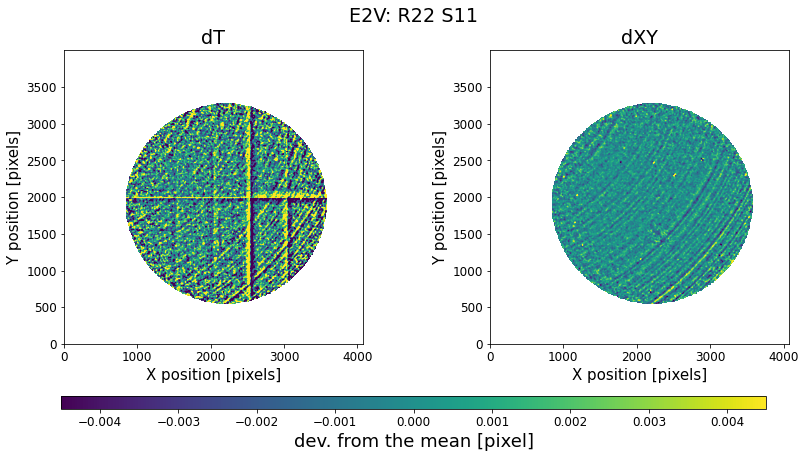

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

imshow(dr_img1,axes[0],title='dT',levels=[-0.0045,0.0045])
im0 = imshow(dt_img1,axes[1],title='dXY',levels=[-0.0045,0.0045],show_colorbar=True)

fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.03])
cbar = fig.colorbar(im0,cax= cbar_ax, orientation='horizontal')
cbar.set_label(ylabel, fontsize=18)
cbar.ax.tick_params(labelsize=12)

plt.suptitle(title)

In [50]:
levels = [-0.0045,0.0045]

In [51]:
_,_,dr_img =  generate_image(self,'dXX',fradius=140)
_,_,dt_img =  generate_image(self,'dYY',fradius=140)

dr_img1 = apply_filter(dr_img, 250, power=4)
dt_img1 = apply_filter(dt_img, 150, power=4)

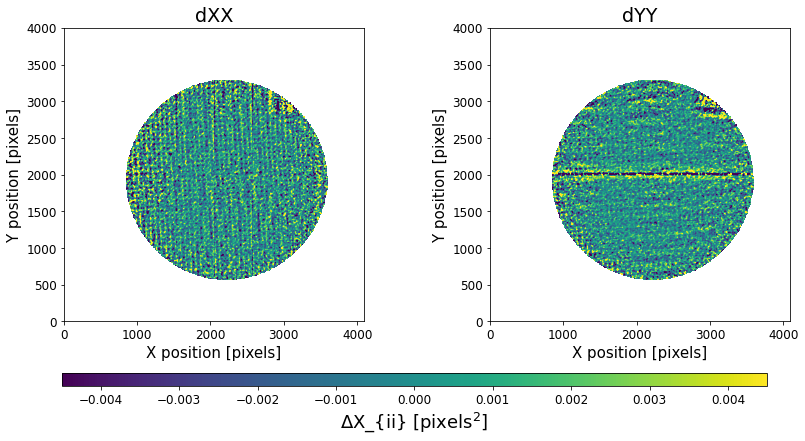

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

imshow(dr_img1,axes[0],title='dXX',levels=levels)
im0 = imshow(dt_img1,axes[1],title='dYY',levels=levels,show_colorbar=True)

fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.03])
cbar = fig.colorbar(im0,cax= cbar_ax, orientation='horizontal')
cbar.set_label(r'$\Delta$X_{ii} [$\mathrm{pixels}^2$]', fontsize=18)
cbar.ax.tick_params(labelsize=12)

# Astrometric Shift

In [53]:
_,dr_img,_ =  generate_image(self,'dr',fradius=140)
_,dt_img,_ =  generate_image(self,'dtheta',fradius=140)

dr_img1 = apply_filter(dr_img, 250, power=4)
dt_img1 = apply_filter(dt_img, 250, power=4)

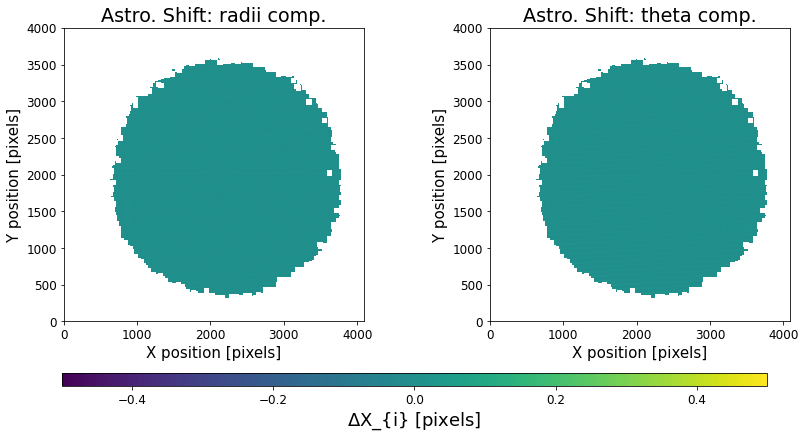

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

imshow(dr_img1,axes[0],title='Astro. Shift: radii comp.',levels=[-0.5,0.5])
im0 = imshow(dt_img1,axes[1],title='Astro. Shift: theta comp.',levels=[-0.5,0.5],show_colorbar=True)

fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.03])
cbar = fig.colorbar(im0,cax= cbar_ax, orientation='horizontal')
cbar.set_label(r'$\Delta$X_{i} [$\mathrm{pixels}$]', fontsize=18)
cbar.ax.tick_params(labelsize=12)

# Ellipticity Analysis

In [39]:
_,dr_img,_ =  generate_image(e2v,'dgr',fradius=130)
_,dt_img,_ =  generate_image(e2v,'dgt',fradius=130)

dr_img1 = 100*apply_filter(dr_img, 250, power=4)
dt_img1 = 100*apply_filter(dt_img, 250, power=4)

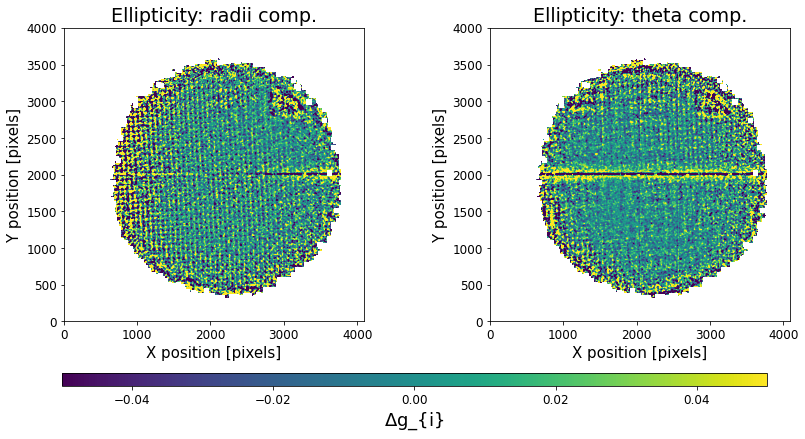

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

imshow(dr_img1,axes[0],title='Ellipticity: radii comp.',levels=[-0.05,0.05])
im0 = imshow(dt_img1,axes[1],title='Ellipticity: theta comp.',levels=[-0.05,0.05],show_colorbar=True)

fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.03])
cbar = fig.colorbar(im0,cax= cbar_ax, orientation='horizontal')
cbar.set_label(r'$\Delta$g_{i}', fontsize=18)
cbar.ax.tick_params(labelsize=12)

In [57]:
def plot_radial_fit(pos,v):
    lo,hi = np.percentile(pos[np.isfinite(v)], [1,99])
    window = 500

    mids,stds = [],[]
    for _ in np.linspace(lo, hi-window, 100):
        idx = np.isfinite(v) & (pos >= _) & (pos < _+window)
        stds.append(np.std(v[idx]))
        mids.append(np.mean(pos[idx]))

    mids = np.array(mids)
    stds = np.array(stds)

    ax=plt.subplot(211)
    plt.plot(mids, stds, lw=3, alpha=1)
    plt.xlim(lo,hi)
    plt.xlabel('Radius, pixels')
    plt.ylabel('Standard deviation')
    #plt.title('E2V - RM-024, R22 S11')

    #plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))

    def fn(p):
        return p[0] + p[1]*(mids/4000)**p[2] - stds

    def fn4(p):
        return p[0] + p[1]*(mids/4000)**4 - stds

    p,_ = opt.leastsq(fn, [0.0, 1e-4, 4.0])
    plt.plot(mids, p[0] + p[1]*(mids/4000)**p[2], '-', color='red', label="%.2g + %.2g*(r/4000)^%.2g" % (p[0], p[1], p[2]))

    p,_ = opt.leastsq(fn4, [0.0, 1e-4])
    plt.plot(mids, p[0] + p[1]*(mids/4000)**4, '-', color='green', label="%.2g + %.2g*(r/4000)^%.2g" % (p[0], p[1], 4.0), ls='--')

    plt.legend(frameon=True)

<ipython-input-57-d26d6fcf50ac>:16: UserWarning: Attempting to set identical left == right == -0.025200811935820872 results in singular transformations; automatically expanding.
  plt.xlim(lo,hi)
<ipython-input-57-d26d6fcf50ac>:24: RuntimeWarning: invalid value encountered in power
  return p[0] + p[1]*(mids/4000)**p[2] - stds
<ipython-input-57-d26d6fcf50ac>:33: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(mids, p[0] + p[1]*(mids/4000)**4, '-', color='green', label="%.2g + %.2g*(r/4000)^%.2g" % (p[0], p[1], 4.0), ls='--')


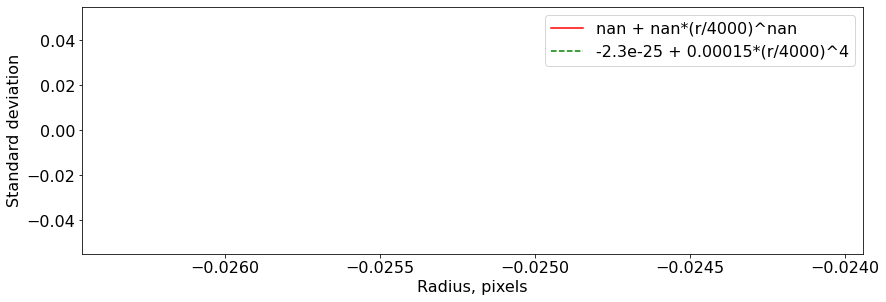

In [58]:
plot_radial_fit(dr[0],dr[1])

<ipython-input-57-d26d6fcf50ac>:16: UserWarning: Attempting to set identical left == right == -0.025200811935820872 results in singular transformations; automatically expanding.
  plt.xlim(lo,hi)
<ipython-input-57-d26d6fcf50ac>:24: RuntimeWarning: invalid value encountered in power
  return p[0] + p[1]*(mids/4000)**p[2] - stds
<ipython-input-57-d26d6fcf50ac>:33: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(mids, p[0] + p[1]*(mids/4000)**4, '-', color='green', label="%.2g + %.2g*(r/4000)^%.2g" % (p[0], p[1], 4.0), ls='--')


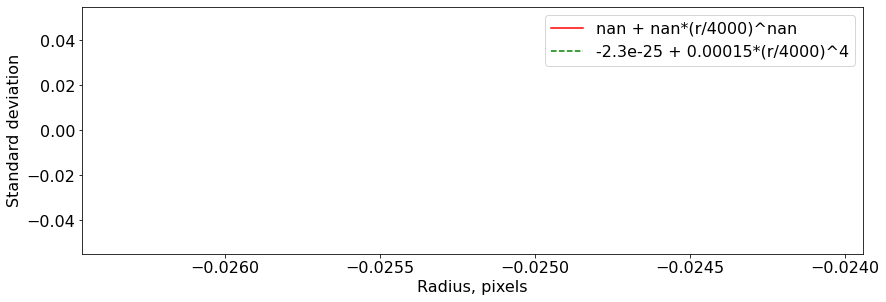

In [59]:
plot_radial_fit(dr[0],dgr[1])

In [60]:
plot_radial_fit(dr[0],dT[1])

IndexError: invalid index to scalar variable.

In [ ]:
r4000 = 0.0017+0.00075
g4000 = 6.6e-5+4.7e-5
dt4000 = 0.00098+0.0008

ratio = r4000/g4000
ratio2= r4000/dt4000

print(ratio)
print(ratio2)